# Modelling & Evaluation Notebook 

## Objectives
- Fit and evaluate a classification model to predict house prices.

## Inputs
- outputs/datasets/collection/HousePrices.csv
- Instructions on whch variables to use for data cleaning and feature engineering. These are found in each respective notebook

## Outputs
- Train set
- Test set
- Data cleaning and feature engineering pipeline
- Modeling pipeline
- Feature importance plot

---

## Change working directory
Change current working directory to its parent

In [2]:
import os 
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(cwd))
print("You set a new current working directory")

You set a new current working directory


In [4]:
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing'

---

## Step 1: Load Data

In [ ]:
import numpy as np
import pandas as pd

# dropping ['WoodDeckSF', 'EnclosedPorch'] as discussed in 02DataCleaning
df = (pd.read_csv("outputs/datasets/collection/HousingPrices.csv").drop(labels=['WoodDeckSF', 'EnclosedPorch'], axis=1))

print(df.shape)
df.head()

(1460, 28)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,SalePrice,HouseAge,RemodAge,GarageAge,TotalSF,AboveGradeSF,IsRemodeled,Has2ndFlr,HasPorch,HasDeck
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,1710,...,208500,22,22,22.0,2566.0,1710.0,0,1,0,0
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1262,...,181500,49,49,49.0,2524.0,1262.0,0,0,0,0
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,1786,...,223500,24,23,24.0,2706.0,1786.0,1,1,0,0
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1717,...,140000,110,55,27.0,1717.0,961.0,1,0,0,0
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2198,...,250000,25,25,25.0,2290.0,1145.0,0,0,0,0


## Step 2: ML Pipeline

### ML Pipeline for Data Cleaning and Feature Engineering

In [11]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer, CategoricalImputer
from feature_engine.transformation import LogTransformer, PowerTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.discretisation import EqualWidthDiscretiser
from sklearn.base import BaseEstimator, TransformerMixin


# data cleaning
def get_cleaning_pipeline():
    cleaning_pipeline = Pipeline([
        ( 'median',  MeanMedianImputer(imputation_method='median',
                                        variables=['LotFrontage', 'BedroomAbvGr', 'MasVnrArea']) ),
        ( 'zero_variables',  ArbitraryNumberImputer(arbitrary_number=-0,
                                                    variables=['2ndFlrSF', 'GarageAge']) ),
        ( 'cat_imputer',  CategoricalImputer(imputation_method='missing',
                                            variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure']) )
    ])

    return cleaning_pipeline

# feature engineering
# ordinal encoding
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping_KitchenQual = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1}
        self.mapping_BsmtExposure = {'Gd':5, 'Av':4, 'Mn':3, 'No':2, 'Missing':1}
        self.mapping_BsmtFinType1 = {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, 'Missing':1}
        self.mapping_GarageFinish = {'Fin':4, 'RFn':3, 'Unf':2, 'Missing':1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['KitchenQual_enc'] = X['KitchenQual'].map(self.mapping_KitchenQual)
        X['BsmtExposure_enc'] = X['BsmtExposure'].map(self.mapping_BsmtExposure)
        X['BsmtFinType1_enc'] = X['BsmtFinType1'].map(self.mapping_BsmtFinType1)
        X['GarageFinish_enc'] = X['GarageFinish'].map(self.mapping_GarageFinish)
        X.drop(columns=['KitchenQual', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish'], inplace=True)
        return X

# numerical pipeline
def get_numerical_pipeline():
    winsor_vars = ['GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'AboveGradeSF']
    log_vars = ['1stFlrSF', 'GrLivArea', 'AboveGradeSF']
    power_vars = ['TotalSF']

    numerical_pipeline = Pipeline([
        ('winsorizer',  Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsor_vars)),
        ('log_transformer', LogTransformer(variables=log_vars)),
        ('power_transformer', PowerTransformer(variables=power_vars)),
        ('discretiser', EqualWidthDiscretiser(bins=5, variables=winsor_vars))
    ])

    return numerical_pipeline


def PipelineDataCleaningAndFeatureEngineering():
    cleaning_pipeline = get_cleaning_pipeline()
    ordinal_encoder = OrdinalEncoder()
    numerical_pipeline = get_numerical_pipeline()
    
    pipeline_base = Pipeline([
        ('cleaning', cleaning_pipeline),
        ('ordinal_encoder', ordinal_encoder),
        ('numerical_pipeline', numerical_pipeline)
    ])

    return pipeline_base

      

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [12]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

In [13]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


### Handle Target Imbalance

In [15]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


Check Train Set Target distribution

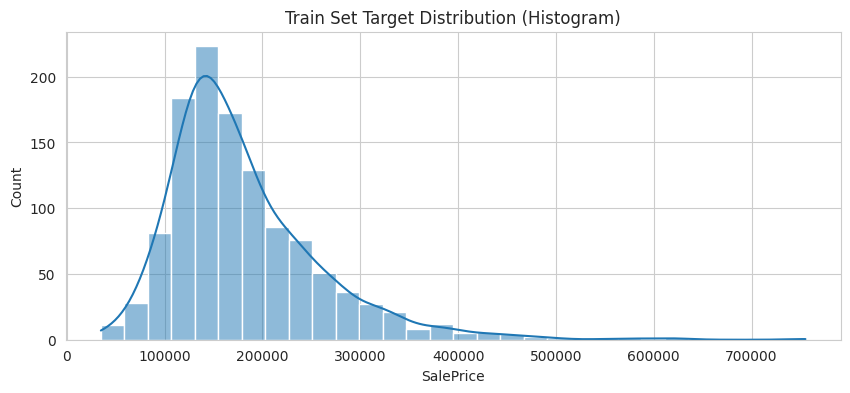

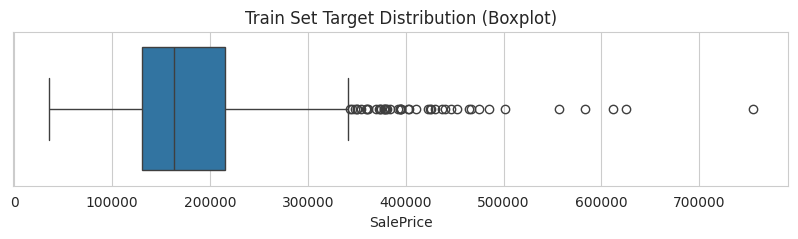

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Train Set Target Distribution (Histogram)")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=y_train)
plt.title("Train Set Target Distribution (Boxplot)")
plt.xlabel("SalePrice")
plt.show()